In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
#import loompy
import matplotlib as mpl
import harmonypy as hm

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.settings.set_figure_params(dpi=80, color_map='viridis')
#sc.logging.print_versions()

### Merge

In [ ]:
healthy = '/lustre/scratch117/cellgen/team205/rl20/CTCL/skin_atlas_object/submission_Healthy_no_nan_raw.h5ad'
es = '/lustre/scratch117/cellgen/team205/rl20/CTCL/skin_atlas_object/submission_AD_no_nan_raw.h5ad'
ps = '/lustre/scratch117/cellgen/team205/rl20/CTCL/skin_atlas_object/submission_Psoriasis_no_nan_raw.h5ad'
ctcl = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/CTCL1-8_raw_rmdou.h5ad'

In [ ]:
adata_he = sc.read_h5ad(healthy)
adata_es = sc.read_h5ad(es)
adata_ps = sc.read_h5ad(ps)
adata_ctcl = sc.read_h5ad(ctcl)

In [ ]:
adatas = [adata_he, adata_es, adata_ps, adata_ctcl]

In [ ]:
adata = adatas[0].concatenate(adatas[1:], join='inner', batch_key='integrated_sample_id', 
                              batch_categories=['Healthy','AD','Psoriasis','CTCL'], index_unique='-')

In [ ]:
save_file = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/CTCL1-8_skin_atlas_integration_raw_no_nan.h5ad'
adata.write(save_file)

### Process

In [2]:
input_file = '/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/CTCL1-8_skin_atlas_integration_raw_no_nan.h5ad'
adata = sc.read_h5ad(input_file)

In [23]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

filtered out 2147 cells that have less than 200 genes expressed
filtered out 3912 genes that are detected in less than 3 cells


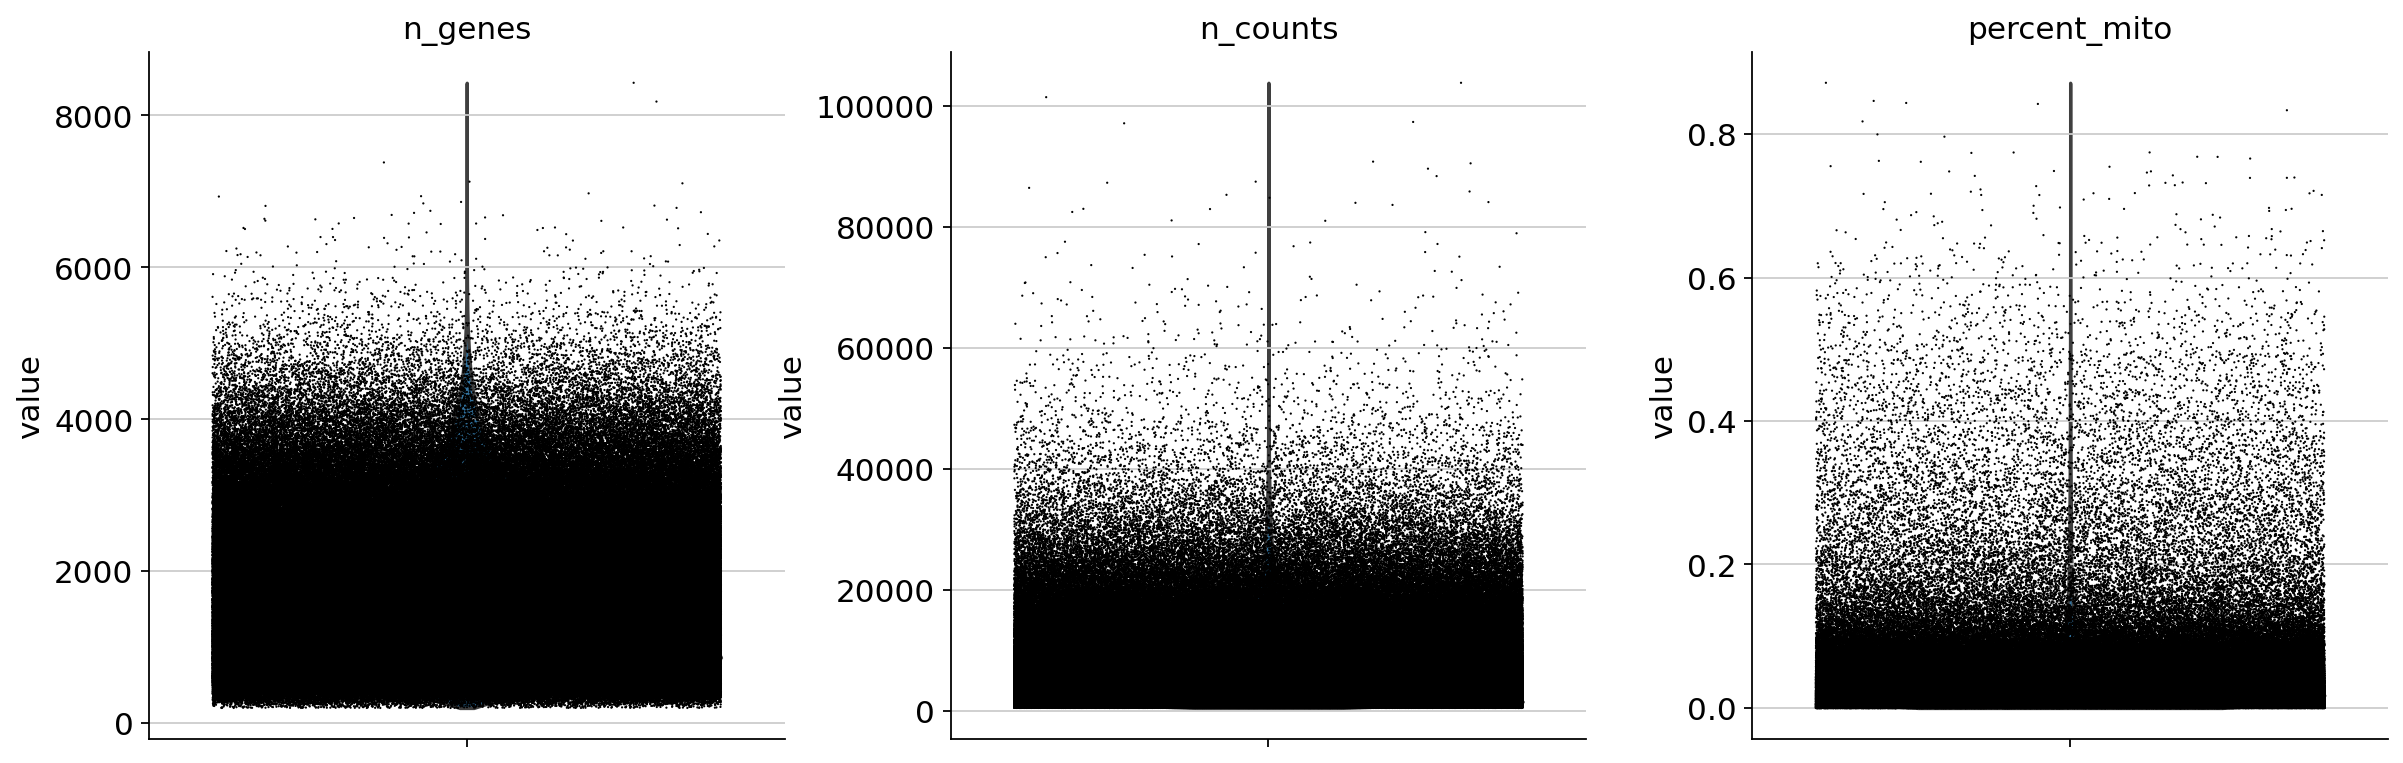

In [24]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [25]:
adata = adata[adata.obs['percent_mito'] < 0.2, :]

In [8]:
#adata_backup_raw = adata.copy()
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:25): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:26)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


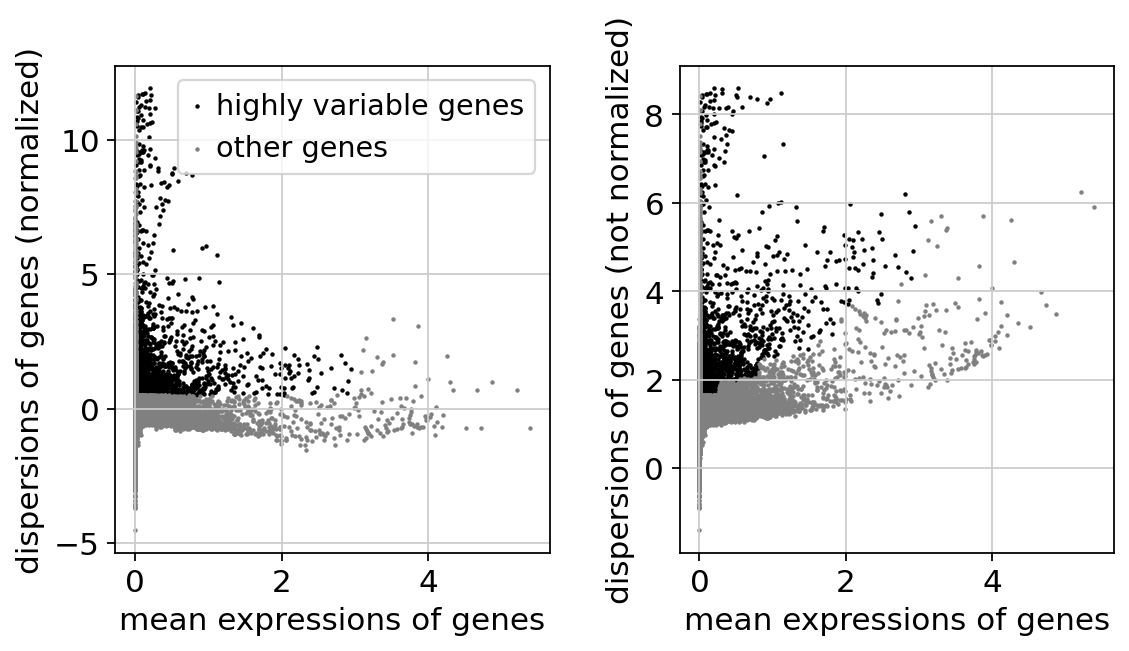

In [9]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [10]:
adata_filtered = adata[:, adata.var['highly_variable']]

In [11]:
sc.pp.regress_out(adata_filtered, ['percent_mito']) ### slow

regressing out ['percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:34:58)


In [12]:
sc.pp.scale(adata_filtered, max_value=10)

Compute PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:51)


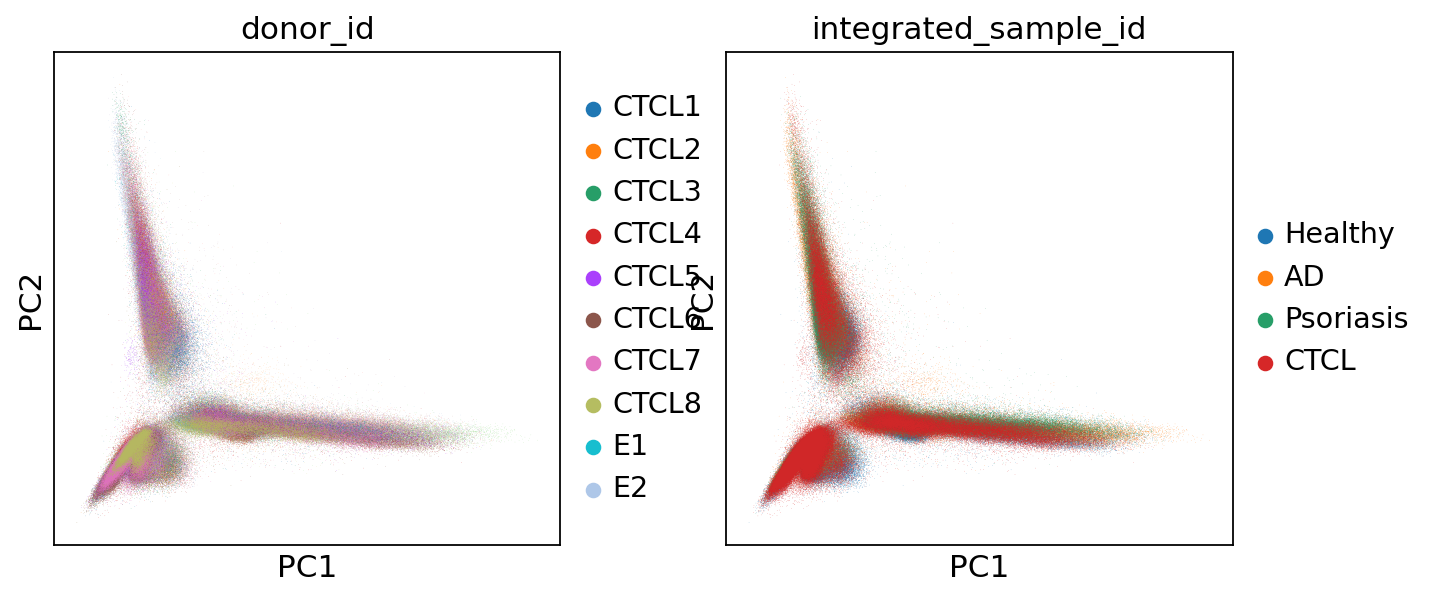

In [13]:
sc.tl.pca(adata_filtered, svd_solver='arpack', random_state=1234)
sc.pl.pca(adata_filtered, color = ['donor_id','integrated_sample_id'])

## Batch correction using harmony

In [15]:
adata_filtered_harmony = adata_filtered.copy()

In [16]:
#Set harmony variables
pca = np.array(adata_filtered_harmony.obsm["X_pca"])
batch = adata_filtered_harmony.obs['donor_id']
meta_data = adata_filtered_harmony.obs

#Run Harmony
ho = hm.run_harmony(pca, meta_data, ['donor_id'], theta = 3, random_state = 1234)
res = (pd.DataFrame(ho.Z_corr)).T
res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]

#Insert coordinates back into object
adata_filtered_harmony.obsm["X_pca_back"]= adata_filtered_harmony.obsm["X_pca"][:]
adata_filtered_harmony.obsm["X_pca"] = np.array(res)

2021-11-02 12:50:20,872 - harmonypy - INFO - Iteration 1 of 10
2021-11-02 13:02:20,616 - harmonypy - INFO - Iteration 2 of 10
2021-11-02 13:14:27,661 - harmonypy - INFO - Iteration 3 of 10
2021-11-02 13:26:25,457 - harmonypy - INFO - Iteration 4 of 10
2021-11-02 13:36:11,942 - harmonypy - INFO - Iteration 5 of 10
2021-11-02 13:42:11,526 - harmonypy - INFO - Converged after 5 iterations


In [17]:
sc.pp.neighbors(adata_filtered_harmony, n_neighbors=15, n_pcs=50, random_state = 1234)
sc.tl.umap(adata_filtered_harmony)

computing neighbors
    using 'X_pca' with n_pcs = 50


/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/numba/core/typed_passes.py:327: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/jovyan/my-conda-envs/myenv_old/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../my-c

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:06:11)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:21:33)


#### add LR predictions

In [7]:
lr_pre = pd.read_csv("/home/jovyan/farm/CTCL/LR-for-CTCL1-8-down0.3/final_lr_metadata_for_adata2.1.csv")
lr_pre

pre_freq_clus_prediction post_freq_clus_prediction
AAACCTGAGAAGCCCA-1-CTCL           Differentiated_KC       Undifferentiated_KC
AAACCTGAGAATGTTG-1-CTCL          Differentiated_KC*       Undifferentiated_KC
AAACCTGAGCGTTCCG-1-CTCL         Undifferentiated_KC       Undifferentiated_KC
AAACCTGAGTACGTTC-1-CTCL           Differentiated_KC         Differentiated_KC
AAACCTGAGTCTCGGC-1-CTCL           Differentiated_KC         Differentiated_KC
...                                             ...                       ...
TTTGTCATCAACGCTA-1-40-CTCL                    MigDC                    moDC_3
TTTGTCATCACGCGGT-1-40-CTCL                    MigDC                     MigDC
TTTGTCATCCAGATCA-1-40-CTCL                       Th                        Th
TTTGTCATCGGTCTAA-1-40-CTCL                      DC2                       DC2
TTTGTCATCTTGTATC-1-40-CTCL                   moDC_3                    moDC_3

[288859 rows x 2 columns]

In [9]:
adata_filtered_harmony.obs['LR_pre_pre'] = adata_filtered_harmony.obs['full_clustering'].copy()
adata_filtered_harmony.obs['LR_pre_post'] = adata_filtered_harmony.obs['full_clustering'].copy()

In [11]:
ctcl = pd.isna(adata_filtered_harmony.obs['LR_pre_pre'])
ctcl.value_counts()

False    445556
True     288859
Name: LR_pre_pre, dtype: int64

In [17]:
adata_filtered_harmony.obs.loc[ctcl, 'LR_pre_pre'] = lr_pre['pre_freq_clus_prediction'].tolist()
adata_filtered_harmony.obs.loc[ctcl, 'LR_pre_post'] = lr_pre['post_freq_clus_prediction'].tolist()

In [18]:
def generate_colors(col_required):
    import random
    number_of_colors = col_required
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    return list(color)

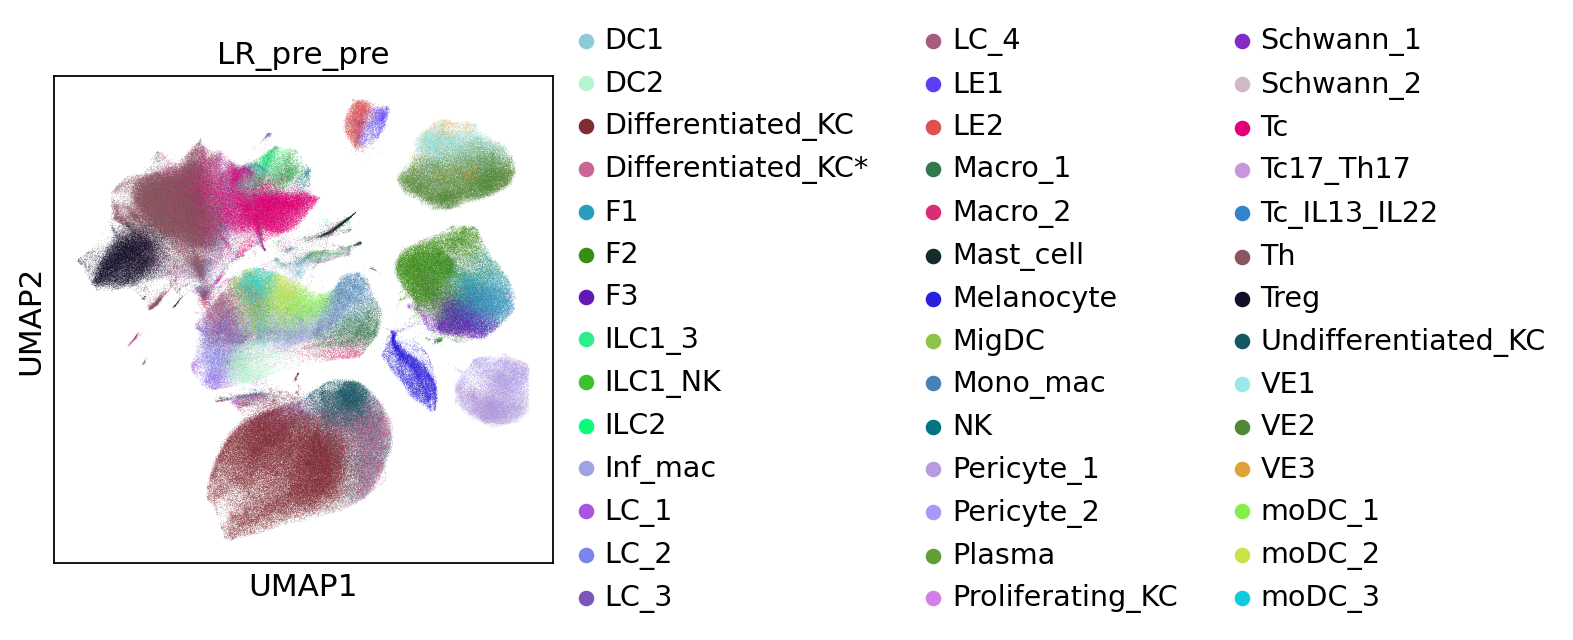

In [19]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
col = generate_colors(len(adata_filtered_harmony.obs["LR_pre_pre"].unique()))
sc.pl.umap(adata_filtered_harmony, color=['LR_pre_pre'], palette = col)

#### Clustering

In [23]:
sc.tl.leiden(adata_filtered_harmony, resolution=1.0, key_added='leiden_1.0')

running Leiden clustering
    finished: found 37 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:19:11)


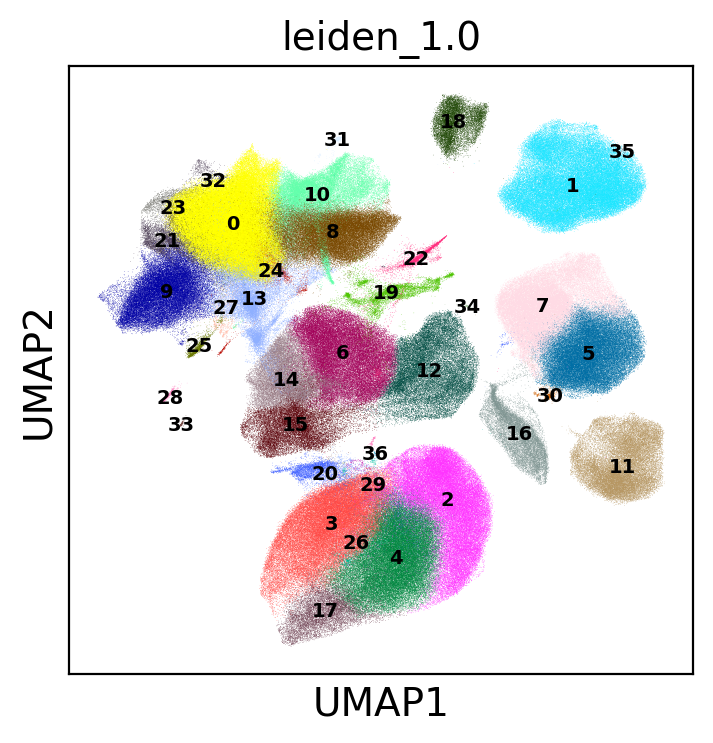

In [4]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony, color=['leiden_1.0'],legend_loc='on data',legend_fontsize=7)

In [ ]:
sc.tl.leiden(adata_filtered_harmony, resolution=0.2, key_added='leiden_1.0_c10_0.2', restrict_to = ('leiden_1.0', ['10']))

In [ ]:
mye_dict = {'0':'T-cell',
            '1':'V-Endo', 
            '2':'KC',
            '3':'KC',
            '4':'KC',
            '5':'Fibro',
            '6':'APC',
            '7':'Fibro',
            '8':'T-cell',
            '9':'T-cell',
            '10,0':'NK/ILC',
            '10,1':'T-cell',
            '10,2':'T-cell',
            '10,3':'T-cell',
            '10,4':'T-cell',
            '11':'Pericyte',
            '12':'APC',
            '13':'T-cell',
            '14':'APC',
            '15':'APC',
            '16':'Melanocyte',
            '17':'KC',
            '18':'L-Endo',
            '19':'B/Plasma',
            '20':'KC',
            '21':'T-cell',
            '22':'Mast',
            '23':'T-cell',
            '24':'T-cell',
            '25':'T-cell',
            '26':'KC',
            '27':'T-cell',
            '28':'T-cell',
            '29':'KC',
            '30':'Fibro',
            '31':'31',
            '32':'T-cell',
            '33':'33',
            '34':'APC',
            '35':'V-Endo',
            '36':'KC'
           }
adata_filtered_harmony.obs['broad_cell_type'] = adata_filtered_harmony.obs['leiden_1.0_c10_0.2'].map(mye_dict)
adata_filtered_harmony_sub = adata_filtered_harmony[~adata_filtered_harmony.obs['broad_cell_type'].isin(['31','33'])]

Trying to set attribute `.uns` of view, copying.


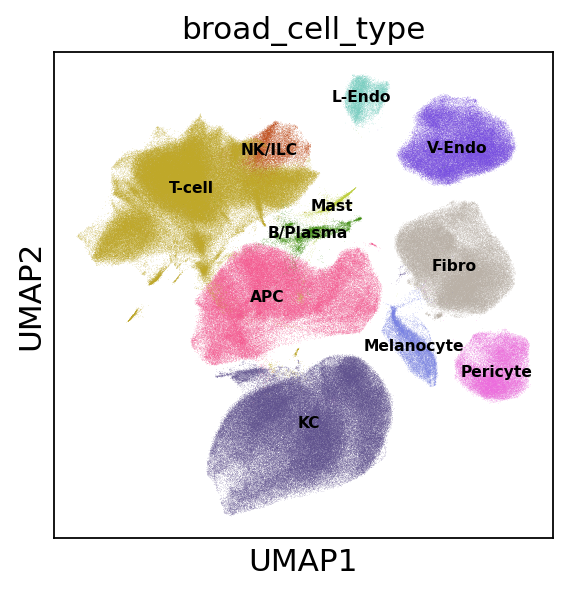

In [7]:
sc.settings.set_figure_params(dpi=80, facecolor='white')
col = ['#F35B92','#3E8D0E','#BAB1A7','#60528F',
 '#75CFC1','#BFD03F','#7982E3','#C2501E','#EC6CDD',
 '#BFA829','#794FE0','#A1208F']
sc.pl.umap(adata_filtered_harmony_sub, color=['broad_cell_type'], legend_loc='on data', legend_fontsize=7,
          palette = col)


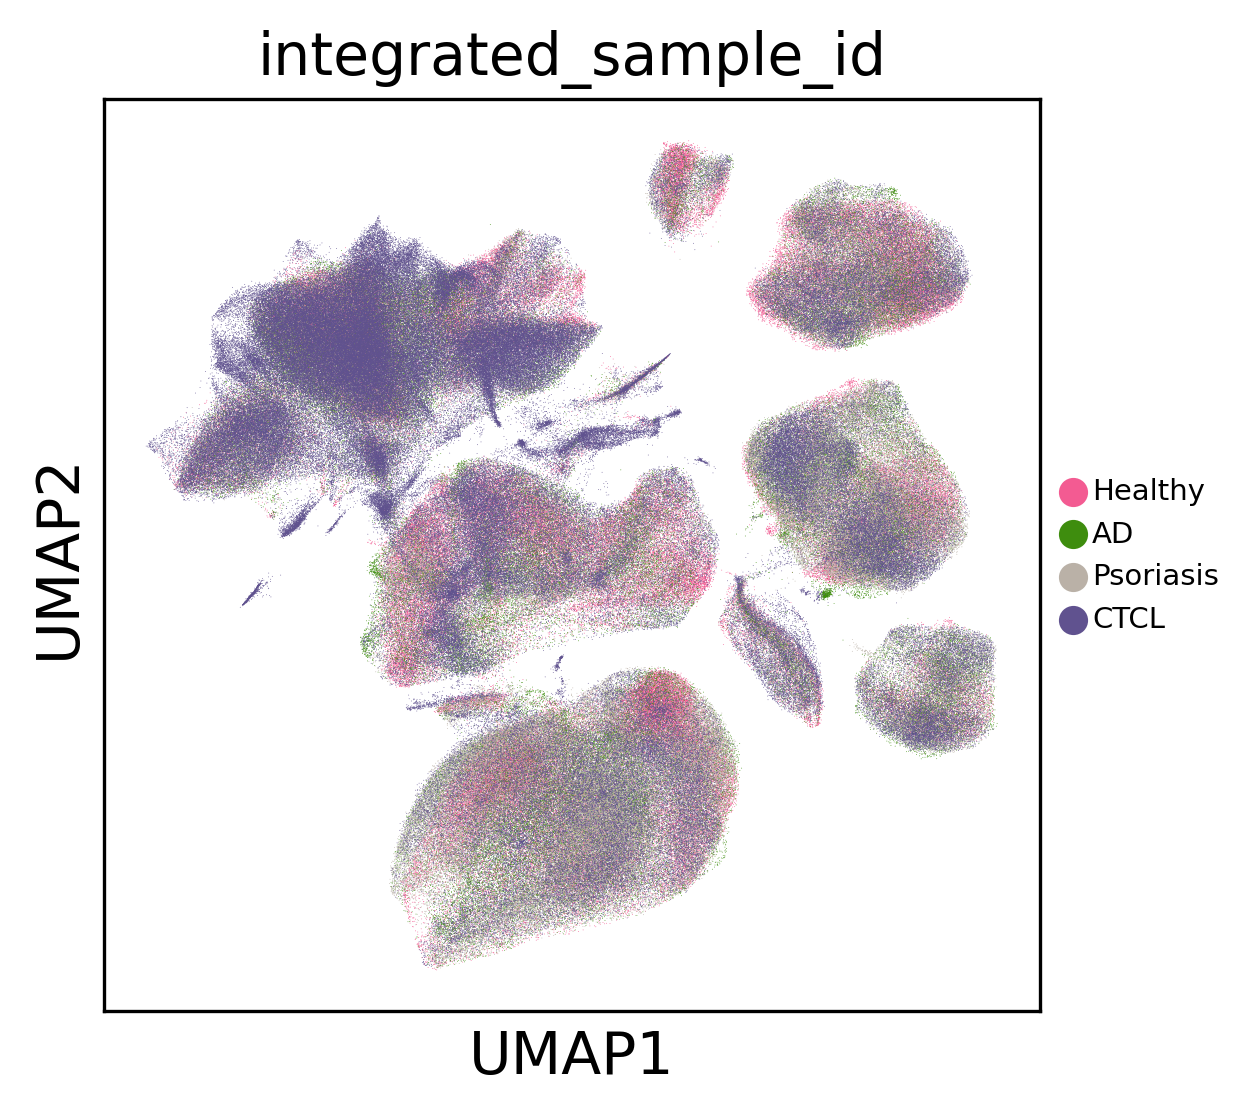

In [7]:
sc.settings.set_figure_params(dpi=150, facecolor='white')
sc.pl.umap(adata_filtered_harmony_sub, color=['integrated_sample_id'], legend_fontsize=7,
          palette = col)

In [71]:
Site_condition = [i + '_' +j for i, j in zip(list(adata_filtered_harmony_sub.obs['integrated_sample_id']), list(adata_filtered_harmony_sub.obs['Site']))]
adata_filtered_harmony_sub.obs['Site_condition'] = Site_condition

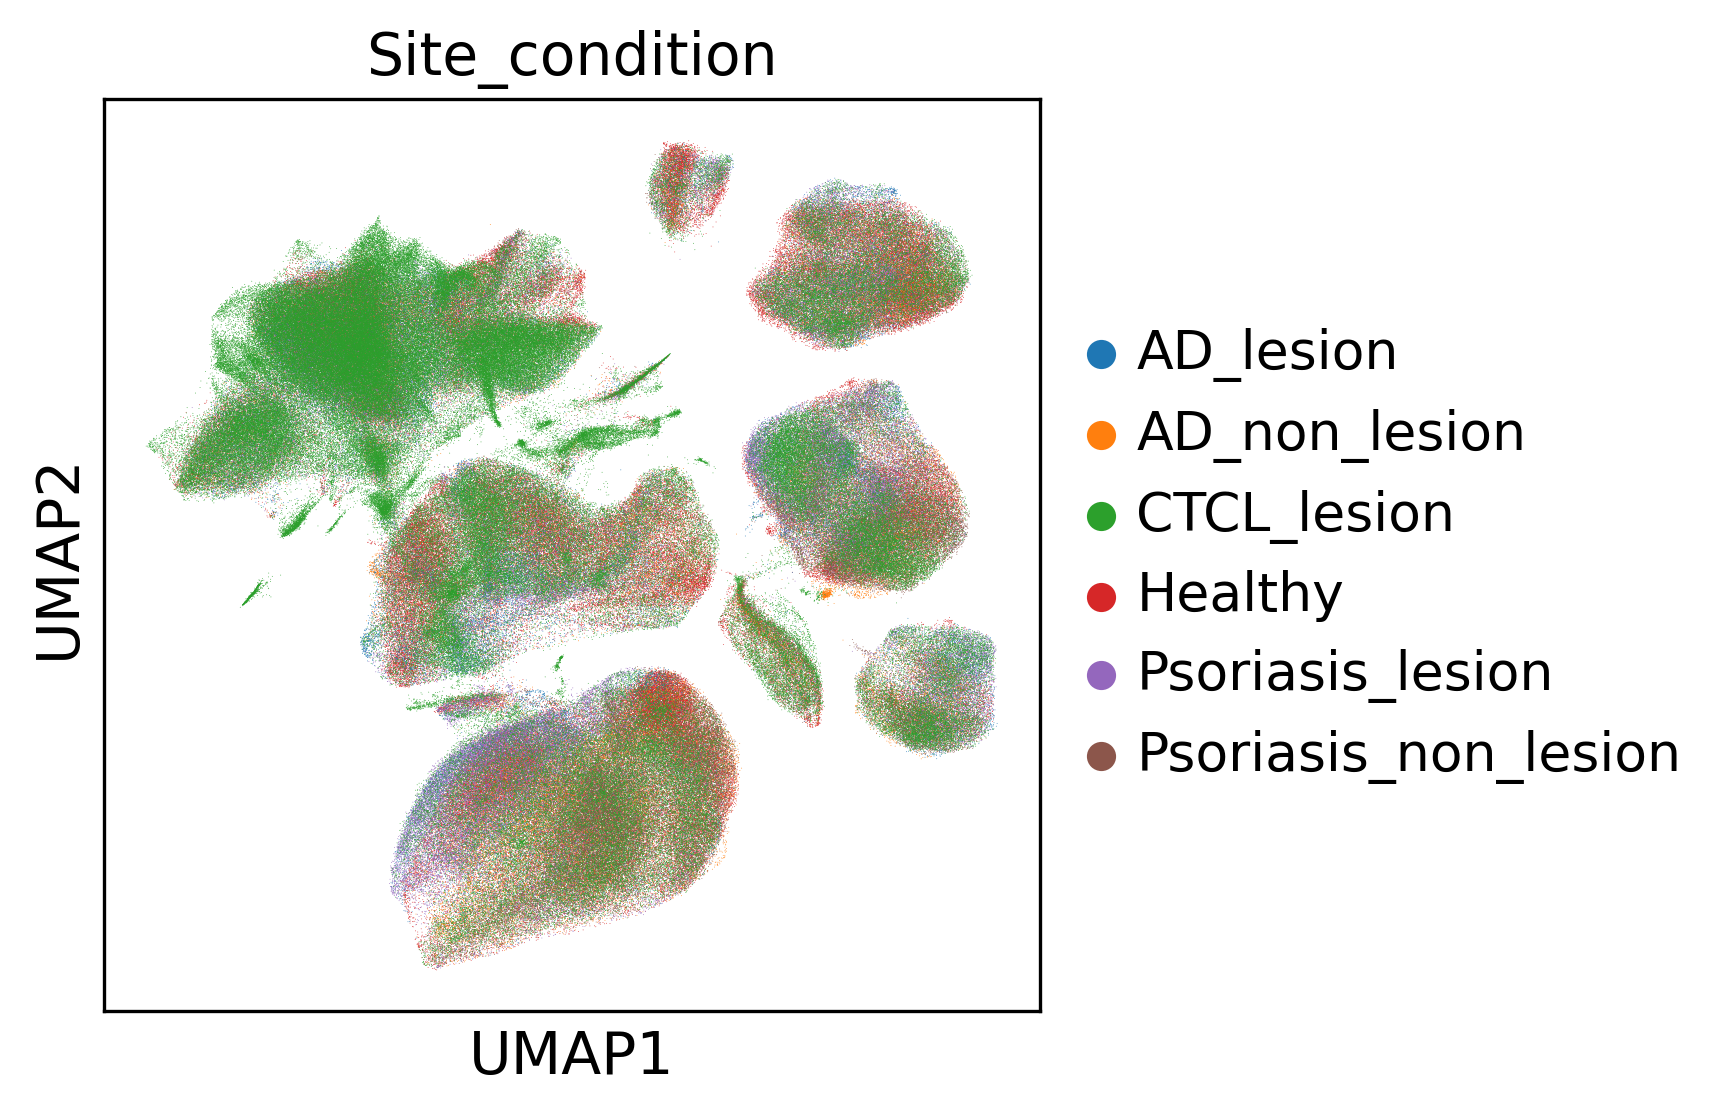

In [24]:
#sc.settings.set_figure_params(dpi=120, facecolor='white')
sc.pl.umap(adata_filtered_harmony_sub, color=['Site_condition'])

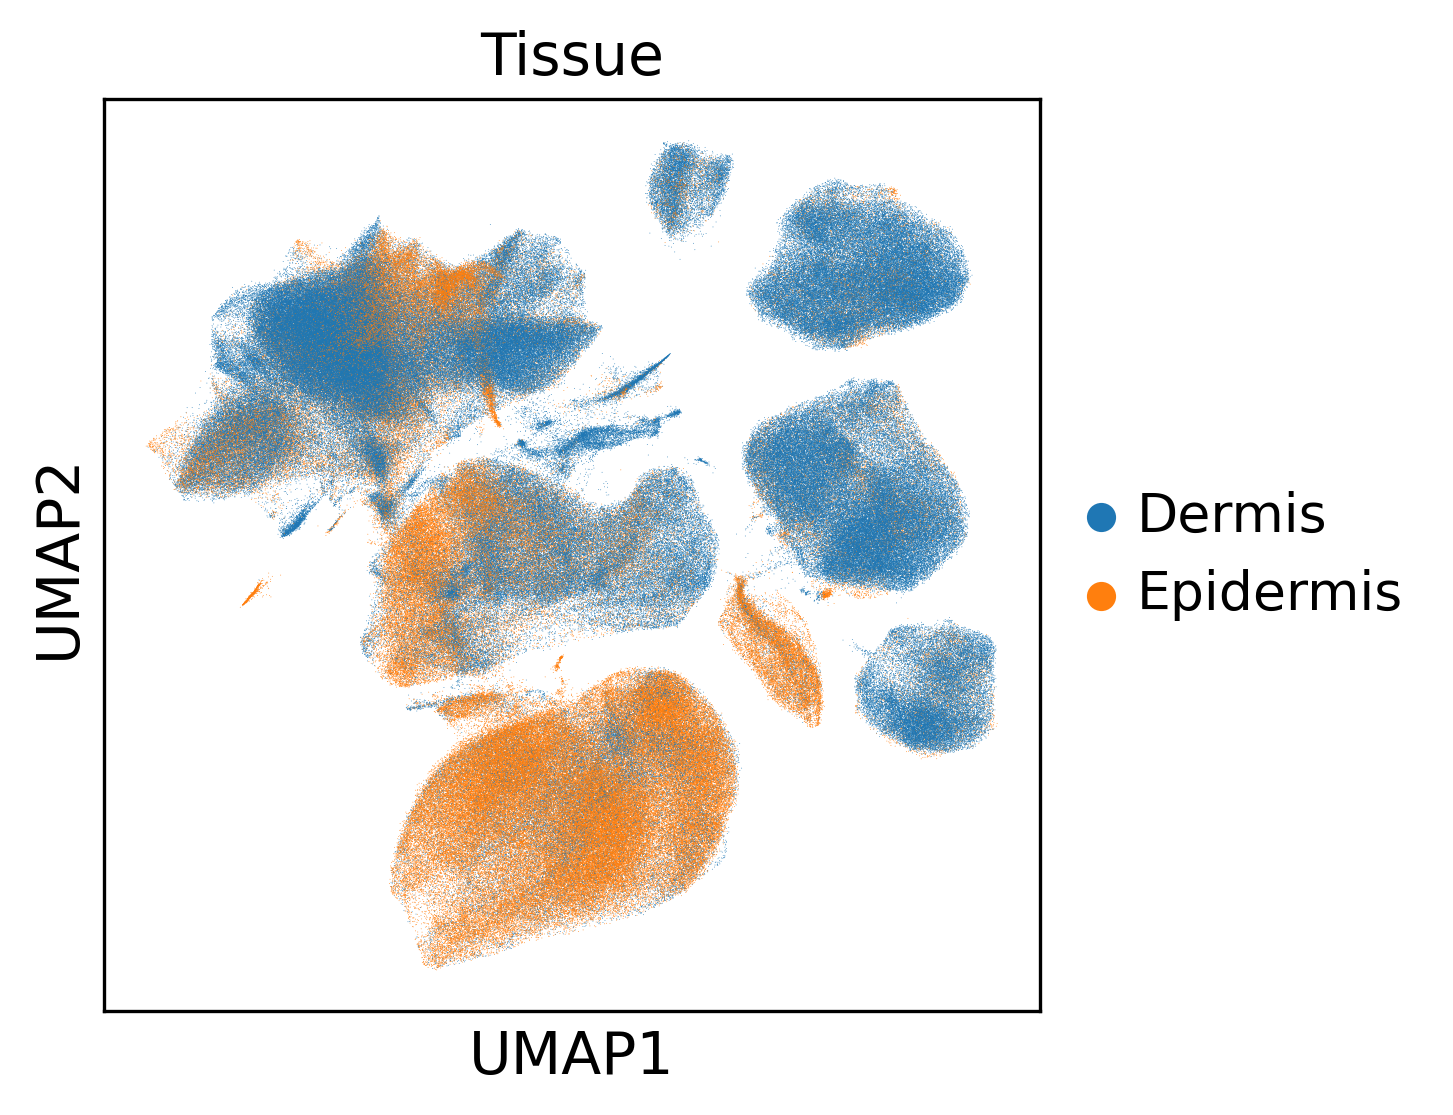

In [25]:
#sc.settings.set_figure_params(dpi=100, facecolor='white')
sc.pl.umap(adata_filtered_harmony_sub, color=['Tissue'])